In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
img=cv2.imread("imori.jpg")
darkimg=cv2.imread("imori_dark.jpg")

In [3]:
def showhist(img,s):
    out=img.copy()
    plt.hist(out.ravel(),bins=255,range=(0,255),rwidth=0.8)
    plt.xlabel("value")
    plt.ylabel("nums")
    plt.savefig(f'{s}.png')
    plt.show()

def write_img(img,s):
    if cv2.imwrite(f'{s}.jpg',img):
        print("ok")
    else:
        print("error")

In [5]:
def hist_normalization(img,a=0,b=255):
    c=img.min()
    d=img.max()
    out=img.copy()
    out[out<c]=a
    out[out>=d]=b
    out[(out>=c) & (out<d)]=(b-a)/(d-c)*(out[(out>=c) & (out<d)]-c)+a
    
    return out.astype(np.uint8)

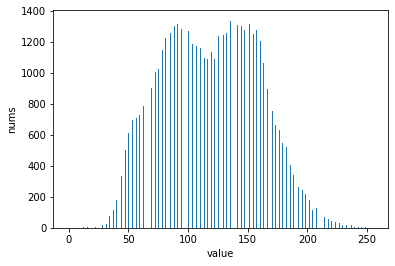

In [6]:
ans1=darkimg.copy().astype(np.float)
ans1=hist_normalization(ans1,a=0,b=255)
cv2.imwrite("ans1img.jpg",ans1)
showhist(ans1,"ans1gragh")

In [7]:
def hist_manipulation(img,m0=128,s0=52):
    m=np.mean(img)
    s=np.std(img)
    
    out=img.copy()
    out=s0/s*(out-m)+m0
    out[out<0]=0
    out[out>255]=255
    return out.astype(np.uint8)

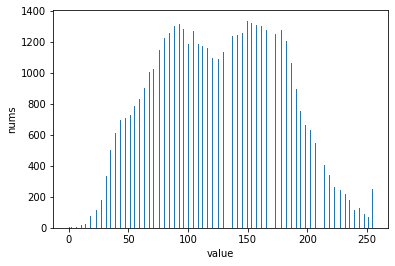

In [8]:
ans2=darkimg.copy()
ans2=hist_manipulation(ans2)
cv2.imwrite("ans2img.jpg",ans2)
showhist(ans2,"ans2gragh")

In [17]:
def hist_equal(img,z_max=255):
    H,W,C=img.shape
    SUM=H*W*C*1.
    
    out=img.copy()
    sum_h=0.
    
    for i in range(256):
        ind=np.where(img==i)
        sum_h+=len(img[ind])
        z_changed=sum_h*z_max/SUM
        out[ind]=z_changed
        
    return out.astype(np.uint8)

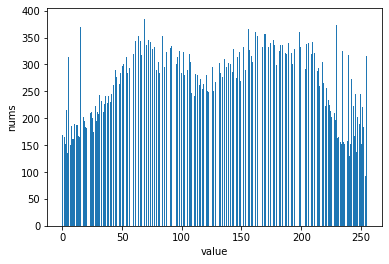

In [18]:
ans3=img.copy()
ans3=hist_equal(ans3)
cv2.imwrite("ans3img.jpg",ans3)
showhist(ans3,"ans3gragh")

In [38]:
def gamma_correction(img,c=1.,g=2.2):
    H,W,C=img.shape
    tmp=img.copy().astype(np.float)
    output=np.zeros_like(img)
    
    output=255*(1/c*tmp/255.)**(1/g)
    
    return output.astype(np.uint8)

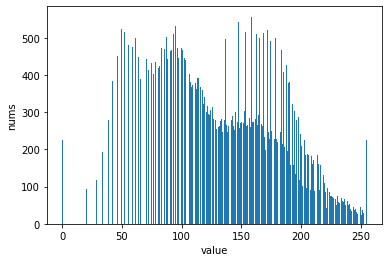

In [43]:
imori_gamma=cv2.imread("imori_gamma.jpg")
ans4=imori_gamma.copy()
ans4=gamma_correction(ans4,g=2.2)
cv2.imwrite("ans4img.jpg",ans4)
showhist(ans4,"ans4gragh")

In [85]:
def nn_interpolate(img,ax=1,ay=1):
    H,W,C=img.shape
    aH=int(ay*H)
    aW=int(ax*W)
    
    #xは列を表すndarray,yは行を表すndarray
    y=np.arange(aH).repeat(aW).reshape(aH,-1)
    x=np.tile(np.arange(aW),(aH,1))
    y=np.round(y/ay).astype(np.int)
    x=np.round(x/ax).astype(np.int)
    
    out=img[y,x]
    out=out.astype(np.uint8)
            
    return out

In [90]:
ans5=img.copy()
print(ans5.shape)
ans5=nn_interpolate(ans5,1.5,1.5)
print(ans5.shape)
cv2.imwrite("ans5.jpg",ans5)

(128, 128, 3)
(192, 192, 3)


True

In [83]:
def Bi_linear(img,ax=1.,ay=1.):
    H,W,C=img.shape
    aH=int(H*ax)
    aW=int(W*ay)
    
    y=np.arange(aH).repeat(aW).reshape(aH,-1)
    x=np.tile(np.arange(aW),(aH,1))
    
    x=x/ax
    y=y/ay
    
    ix=np.minimum(np.floor(x).astype(np.int),W-2)
    iy=np.minimum(np.floor(y).astype(np.int),H-2)
    
    dx=x-ix
    dy=y-iy
    
    dx=np.tile(dx,(C,1)).reshape(aH,aW,C)
    dy=np.tile(dy,(C,1)).reshape(aH,aW,C)
    
    out=(1-dy)*(1-dx)*img[iy,ix]+dy*(1-dx)*img[iy+1,ix]+(1-dy)*dx*img[iy,ix+1]+dy*dx*img[iy+1,ix+1]
    out=np.clip(out,0,255).astype(np.uint8)
    
    return out

In [135]:
ans6=img.copy()
ans6=Bi_linear(img,ax=1.5,ay=1.5)
write_img(ans6,"ans6")

ok


In [122]:
def Bi_cubic(img,ax=1.,ay=1.,a=-1.):
    H,W,C=img.shape
    aH=int(H*ax)
    aW=int(W*ay)
    
    y=np.arange(aH).repeat(aW).reshape(aH,-1)
    x=np.tile(np.arange(aW),(aH,1))
    
    x=(x/ax)
    y=(y/ay)
    
    ix=np.minimum(np.floor(x).astype(np.int),W-1)
    iy=np.minimum(np.floor(y).astype(np.int),H-1)
    
    #d
    dx1=x-ix+1;dx2=x-ix;dx3=x-ix-1;dx4=x-ix-2
    dy1=y-iy+1;dy2=y-iy;dy3=y-iy-1;dy4=y-iy-2
    
    dxs=[dx1,dx2,dx3,dx4]
    dys=[dy1,dy2,dy3,dy4]
    
    def weight(t):
        at=np.abs(t)
        w=np.zeros_like(t)
        ind = np.where(at<=1)
        w[ind] = ((a+2) * np.power(at, 3) - (a+3) * np.power(at, 2) + 1)[ind]
        ind = np.where((at > 1) & (at <= 2))
        w[ind] = (a*np.power(at, 3) - 5*a*np.power(at, 2) + 8*a*at - 4*a)[ind]
        return w
    
    out=np.zeros((aH,aW,C),dtype=np.float32)
    molecule=np.zeros((aH,aW,C),dtype=np.float32)
    denominator=np.zeros((aH,aW,C),dtype=np.float32)
    
    tmp=img.copy().astype(np.float)
    for i in range(-1,3):
        for j in range(-1,3):
            ind_x=np.minimum(np.maximum(ix+i,0),W-1)
            ind_y=np.minimum(np.maximum(iy+j,0),H-1)
            wx=weight(dxs[i+1])
            wy=weight(dys[j+1])
            wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis=-1)
            wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis=-1)
            
            molecule+=wx*wy*tmp[ind_y,ind_x]
            denominator+=wx*wy
    
    out=molecule/denominator
    out=np.clip(out,0,255)
    return out.astype(np.uint8)

In [123]:
ans7=img.copy().astype(np.float)
ans7=Bi_cubic(ans7,ax=1.5,ay=1.5)
write_img(ans7,"ans7")

ok


In [165]:
def Affine_translation(img,tx=30,ty=-30):
    H,W,C=img.shape
    out=np.zeros_like(img)
    
    x=np.arange(W)
    y=np.arange(H)
    xout,yout=np.meshgrid(x,y)
    
    xin=xout-tx
    yin=yout-ty
    ind=np.where((xin<W) & (xin>=0) & (yin<H) & (yin>=0))
    tmp=img.copy()
    out[ind]=tmp[yin[ind],xin[ind]]
    out=out.astype(np.uint8)
    return out

In [166]:
ans8=img.copy()
ans8=Affine_translation(ans8)
write_img(ans8,"ans8")

ok


In [179]:
def Affine_scaling(img,dx=1.3,dy=0.8):
    H,W,C=img.shape
    aH=int(H*dy)
    aW=int(W*dx)
    out=np.zeros((aH,aW,C))
    
    x=np.arange(aW)
    y=np.arange(aH)
    xout,yout=np.meshgrid(x,y)
    
    xin=dy*xout
    yin=dx*yout
    xin/=dx*dy
    yin/=dx*dy
    
    ind=np.where((xin<W) & (xin>=0) & (yin<H) & (yin>=0))
    tmp=img.copy()
    out[ind]=tmp[yin[ind].astype(np.int),xin[ind].astype(np.int)]
    out=out.astype(np.uint8)
    
    return out

def Affine_s_t(img,dx=1.3,dy=0.8,tx=30,ty=-30):
    H,W,C=img.shape
    aH=int(H*dy)
    aW=int(W*dx)
    out=np.zeros((aH,aW,C))
    
    x=np.arange(aW)
    y=np.arange(aH)
    xout,yout=np.meshgrid(x,y)
    
    abcd=dx*dy
    xin=dy*xout/abcd-tx
    yin=dx*yout/abcd-ty
    
    ind=np.where((xin<W) & (xin>=0) & (yin<H) & (yin>=0))
    tmp=img.copy()
    out[ind]=tmp[yin[ind].astype(np.int),xin[ind].astype(np.int)]
    out=out.astype(np.uint8)
    
    return out


In [180]:
ans9=img.copy()
ans9scaling=Affine_scaling(ans9)
write_img(ans9scaling,"ans9scaling")
ans9_s_t=Affine_s_t(ans9)
write_img(ans9_s_t,"ans9_s_t")

ok
ok


In [207]:
def Affine_rotation(img,rot=30):#反時計回りに30度
    rot=-np.pi*rot/180.
    H,W,C=img.shape
    x=np.arange(W)
    y=np.arange(H)
    outx,outy=np.meshgrid(x,y)
    
    a=np.cos(rot)
    c=np.sin(rot)
    b=-c
    d=a
    ad_bc=a*d-b*c
    xin=(d*outx-b*outy)/ad_bc
    yin=(-c*outx+a*outy)/ad_bc
    
    ind=np.where((xin<W) & (xin>=0) & (yin<H) & (yin>=0))
    out=np.zeros_like(img)
    
    out[ind]=img[yin[ind].astype(np.int),xin[ind].astype(np.int)]
    out=out.astype(np.uint8)
    return out

def Affine_rot_mid(img,rot=30):
    theta=-np.pi*rot/180.
    H,W,C=img.shape
    mx=int(W/2)
    my=int(H/2)
    x=np.arange(W)
    y=np.arange(H)
    xout,yout=np.meshgrid(x,y)
    
    a=np.cos(theta)
    c=np.sin(theta)
    b=-c
    d=a
    ad_bc=a*d-b*c
    
    tmpx=xout-mx
    tmpy=yout-my
    xin=(d*tmpx-b*tmpy)/ad_bc+mx
    yin=(-c*tmpx+a*tmpy)/ad_bc+my
    
    ind=np.where((xin<W) & (xin>=0) & (yin<H) & (yin>=0))
    out=np.zeros_like(img)
    
    out[ind]=img[yin[ind].astype(np.int),xin[ind].astype(np.int)]
    out=out.astype(np.uint8)
    return out

In [208]:
ans10=img.copy()
ans10rot1=Affine_rotation(ans10)
write_img(ans10rot1,"ans10rot1")
ans10rot2=Affine_rot_mid(ans10)
write_img(ans10rot2,"ans10rot2")

ok
ok
